In [4]:
from typing import List
import torch
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ase.io
from ase import Atoms
from ase.io import write
from ase.visualize import view
from pathlib import Path
from torch_geometric.data import Data
from rdkit import Chem
from gotennet.models.components.callbacks import evaluate_geometry
from flow_matching.utils import pred_atom_index_align


PRED_PATH = "logs/train_test_error_bar/multiruns/2025-04-11_09-32-05/2/test_samples/samples_all.pkl"
PRED_PATH_TSDIFF = "/home/leonard.galustian/projects/tsdiff-master/reproduce/RDB7/samples_random_split.pkl"
PRED_CSV = 'logs/train_test_error_bar/multiruns/2025-04-11_09-32-05/2/test_results.csv'

In [13]:
with open(PRED_PATH, 'rb') as f:
    pred_R = pickle.load(f)

with open(PRED_PATH_TSDIFF, 'rb') as f:
    pred_tsdiff_R = pickle.load(f)

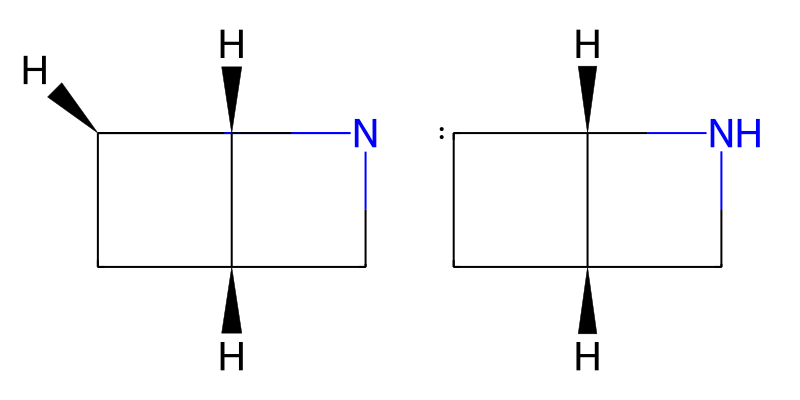

In [ ]:
SAVE_RXN_DATA = 36

def show_rxn_graph(data: Data):
    r_smiles, p_smiles = data.smiles.split('>>')

    # convert the two reactand and product strings to RdKit Mol objects (r_mol, p_mol)
    params = Chem.SmilesParserParams()
    params.removeHs = False
    r_mol, p_mol = Chem.MolFromSmiles(r_smiles, params), Chem.MolFromSmiles(p_smiles, params)
    Chem.SanitizeMol(r_mol)
    Chem.SanitizeMol(p_mol)

    img = Chem.Draw.MolsToGridImage(
        [r_mol, p_mol], 
        #legends=["Reactant", "Product"],
        molsPerRow=2, 
        subImgSize=(400, 400),
    )
    display(img)

def show_rxn_graph_clean(data: Data):
    r_smiles, p_smiles = data.smiles.split('>>')

    # RdKit functions to convert the two reactand and product strings to RdKit Mol objects
    params = Chem.SmilesParserParams()
    params.removeHs = False
    r_mol, p_mol = Chem.MolFromSmiles(r_smiles, params), Chem.MolFromSmiles(p_smiles, params)
    Chem.SanitizeMol(r_mol)
    Chem.SanitizeMol(p_mol)

    # Create copies of molecules without atom mapping numbers
    r_mol_copy = Chem.Mol(r_mol)
    p_mol_copy = Chem.Mol(p_mol)
    
    # Remove atom map numbers from the copies
    for mol in [r_mol_copy, p_mol_copy]:
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(0)  # Setting to 0 removes the mapping number from display

    r_mol_copy = Chem.RemoveAllHs(r_mol_copy)
    p_mol_copy = Chem.RemoveAllHs(p_mol_copy)
    
    # Draw the molecules without atom mapping numbers
    img = Chem.Draw.MolsToGridImage(
        [r_mol_copy, p_mol_copy], 
        molsPerRow=2, 
        subImgSize=(400, 400)
    )
    display(img)


def pred_gt_mol_data_to_xyzs(data: Data, save_dir=Path("temp")):
    pred_pos, gt_pos = pred_atom_index_align(data.smiles, data.pos[:, 1, :], data.pos_gen[-1])
    # Get the molecule from SMILES and sort its atoms by their atom map number
    params = Chem.SmilesParserParams()
    params.removeHs = False
    mol = Chem.MolFromSmiles(data.smiles.split('>>')[0], params=params)
    sorted_atoms = sorted(mol.GetAtoms(), key=lambda atom: atom.GetAtomMapNum())
    symbols = [atom.GetSymbol() for atom in sorted_atoms]

    # Create ASE Atoms objects
    gt_atoms = Atoms(symbols=symbols, positions=gt_pos)
    pred_atoms = Atoms(symbols=symbols, positions=pred_pos)
    ch_pred_pos = pred_pos.clone()
    ch_pred_pos[:,0] = -ch_pred_pos[:,0]
    ch_pred_atoms = Atoms(symbols=symbols, positions=ch_pred_pos)

    # Save the atoms to .xyz files with the SMILES as a comment
    write(save_dir / "pos_gt.xyz", gt_atoms, comment=f"smiles: {data.smiles}")
    write(save_dir / "pos_pred.xyz", pred_atoms, comment=f"smiles: {data.smiles}")

    return gt_atoms, pred_atoms, ch_pred_atoms

gt,pred,ch_pred = pred_gt_mol_data_to_xyzs(pred_R[SAVE_RXN_DATA])
show_rxn_graph_clean(pred_R[SAVE_RXN_DATA])

In [ ]:
view(gt, viewer='ngl')

In [ ]:
view(pred, viewer='ngl')

In [3]:
highest_clash_idx, highest_clash = -1, -1.0
clash_rxns = []
high_mae_rxns = []
bad_chiral_rxns = []
for i, rxn in enumerate(pred_R):
    res = evaluate_geometry(rxn)
    
    # HIGH STERIC CLASH
    if res['steric_clash'] > 150:
        clash_rxns.append((i, rxn, res))
    if res['steric_clash'] > highest_clash:
        highest_clash = res['steric_clash']
        highest_clash_idx = i
    
    # HIGH MAE
    if res['mae'] > 0.31:
        high_mae_rxns.append((i, rxn, res))

    # WRONG CHIRALITY PREDICTED
    rxn_cl = rxn.clone()
    final_ts_N_3 = rxn_cl.pos_gen[-1]
    final_ts_N_3[:, 0] = -final_ts_N_3[:, 0]
    rxn_cl.pos_gen[-1] = final_ts_N_3
    res_chiral = evaluate_geometry(rxn_cl)
    if res_chiral['rmse'] < 0.05*res['rmse']:# and res['mae'] < 0.55:
        bad_chiral_rxns.append((i, rxn, res, res_chiral))

In [ ]:
clash_rxns

In [ ]:
sorted(high_mae_rxns, key=lambda x: x[2]['mae'], reverse=True)

In [ ]:
print(len(bad_chiral_rxns))
bad_chiral_rxns

In [14]:
# compute D-MAE list for TsDiff
mae_list = []
for rxn in pred_tsdiff_R:
    rxn.pos_gen = rxn.pos_gen[None, ...]
    res = evaluate_geometry(rxn)
    mae = res['mae']
    mae_list.append(mae)

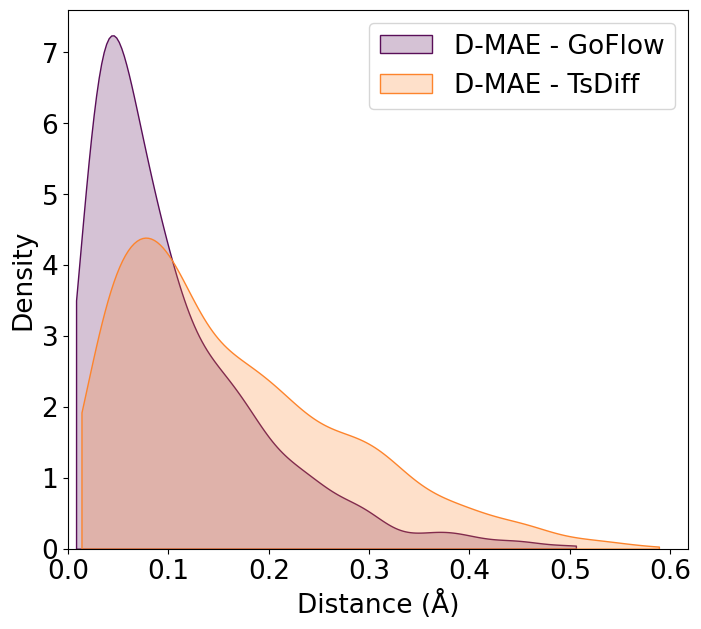

In [16]:
df = pd.read_csv(PRED_CSV)

plt.rcParams.update({'font.size': 19})
plt.figure(figsize=(8, 7))

rgb_color = (89/255, 14/255, 88/255)
tsdiff_color = (253/255, 132/255, 44/255)

# D-MAE from df
sns.kdeplot(
    data=df,
    x='mae',
    fill=True,
    label='D-MAE - GoFlow',
    color=rgb_color,
    common_norm=False,
    cut=0,
    clip=(0, None)
)

# D-MAE for TsDiff from mae_list
sns.kdeplot(
    mae_list,
    fill=True,
    label='D-MAE - TsDiff',
    color=tsdiff_color,
    common_norm=False,
    cut=0,
    clip=(0, None)
)

plt.xlabel('Distance (Å)', fontsize=19)
plt.ylabel('Density', fontsize=19)
plt.legend(fontsize=19)
plt.xlim(0)
plt.savefig("kdeplot.pdf")
plt.show()
